In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install Bio --quiet
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo
/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy


In [3]:
# Loading training dataset
train_terms = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv', sep='\t')
display(train_terms.head())

# Load training sequences
with open('/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta') as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    sequence = []
    seq_name = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        lengths.append(len(seq_record.seq))
        sequence.append(str(seq_record.seq))
        seq_name.append(seq_record.name)
        
train_seq_df = pd.DataFrame({'id': identifiers,
             'seq_length': lengths,
             'sequence': sequence,
             'seq_name': seq_name})
display(train_seq_df.head())

# Load training taxonomy terms
train_taxonomy = pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv', sep='\t')
train_taxonomy.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


,id,seq_length,sequence,seq_name
0,P20536,218,MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...,P20536
1,O73864,354,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...,O73864
2,O95231,258,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,O95231
3,A0A0B4J1F4,415,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...,A0A0B4J1F4
4,P54366,415,MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...,P54366


,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


We will now load the pre calculated protein embeddings created by Sergei Fironov using the Rost Lab's T5 protein language model.

If the tfembeds is not yet on the input data of the notebook, you can add it to your enviromentby clicking on Add Data and search for t5embeds (make sure that it's the correct one ) and then click on the + beside it.

The protein embeddings to be used for training are recorded in train_embeds.npy and the corresponding protein ids are available in train_ids.npy.

In [4]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
display(train_protein_ids.shape)
train_protein_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')
display(train_protein_embeddings.shape)

column_num = train_protein_embeddings.shape[1]
train_embedding_df = pd.DataFrame(train_protein_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_embedding_df.shape)
display(pd.DataFrame(train_protein_ids, columns=['protein_id']).head())
display(train_embedding_df.head())

(142246,)

(142246, 1024)

(142246, 1024)


,protein_id
0,P20536
1,O73864
2,O95231
3,A0A0B4J1F4
4,P54366


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In order to simplify my model, I chose te most frequence 1500 GO term IDs as labels.

In [5]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


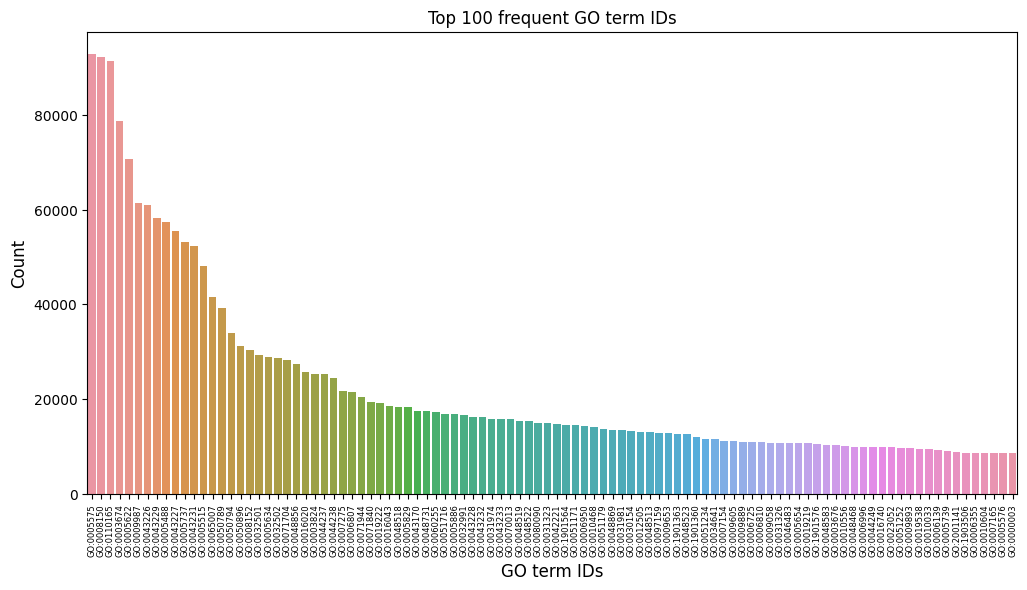

In [6]:
# Select first 100 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [7]:
# Set the limit for label
num_of_labels = 50

# Take value counts in descending order and fetch first 500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

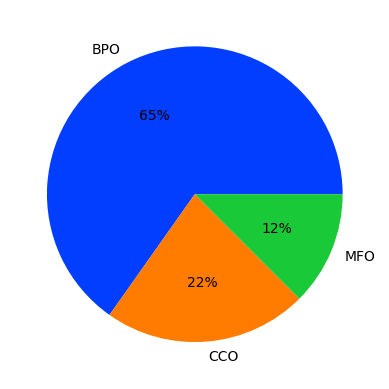

In [8]:
pie_df = train_terms['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

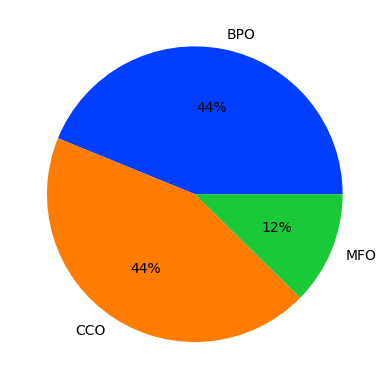

In [9]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

The subsampling maintains the same distribution as in the original dataset.
Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0.
First, we will create a numpy array `train_labels` of required size for the labels. To update the `train_labels` array with the appropriate values, we will loop through the label list.

Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0. First, we will create a numpy array train_labels of required size for the labels. To update the train_labels array with the appropriate values, we will loop through the label list.



In [10]:
train_protein_ids[:10]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366', 'P33681',
       'P77596', 'Q16787', 'Q59VP0', 'P13508'], dtype='<U10')

In [11]:
# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 500)
train_size = train_protein_ids.shape[0] # len(X), there are 142246 protein ids (that contain embeddings) for which 1500 Go terms need to be stored.
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(int)
    

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

(142246, 50)


In [12]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0032991,GO:0043228,GO:0043232,GO:0031974,GO:0043233,GO:0070013,GO:0048519,GO:0048522,GO:0080090,GO:0031323
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training and Testing with Neural Networks

In [13]:
import tensorflow as tf

INPUT_SHAPE = [train_embedding_df.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_embedding_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

2024-05-22 03:56:02.497375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 03:56:02.497539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 03:56:02.657331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - auc: 0.7123 - binary_accuracy: 0.7505 - loss: 0.5120
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - auc: 0.8335 - binary_accuracy: 0.8103 - loss: 0.4079
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - auc: 0.8495 - binary_accuracy: 0.8186 - loss: 0.3915
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step - auc: 0.8579 - binary_accuracy: 0.8235 - loss: 0.3825
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - auc: 0.8659 - binary_accuracy: 0.8287 - loss: 0.3729


# Plot the model's loss and accuracy for each epoch

<Axes: title={'center': 'Accuracy'}>

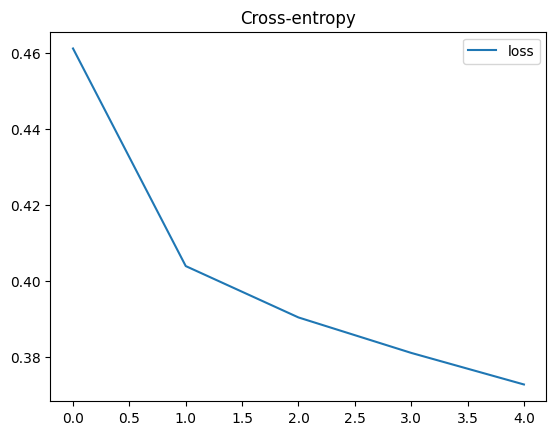

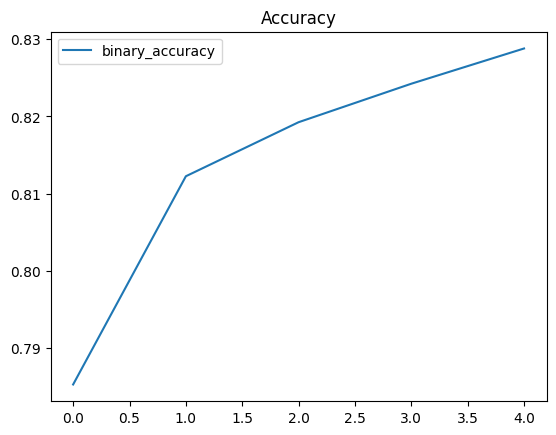

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

# Submission

In [15]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


In [16]:
predictions =  model.predict(test_df)
# This will take 15-20 minutes

4434/4434 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step


In [17]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

## Training and Testing with a Multilabel Classfier
Since many GO terms can be associated with each protein ID, I can think of this as multilabel classifier.
We will begin by coverting labels_df to a numpy sparse array

In [18]:
y = np.asarray(labels_df[labels_df.columns])

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

clf = MultiOutputClassifier(LogisticRegression(random_state=2, solver='newton-cg'), n_jobs=1).fit(train_embedding_df, y)